<a href="https://www.kaggle.com/code/nisaruddinshafi/nov-hackathon?scriptVersionId=111624994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime 


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forecast-green-energy/sample_submission_jn0a7vR.csv
/kaggle/input/forecast-green-energy/test_WudNWDM.csv
/kaggle/input/forecast-green-energy/train_IxoE5JN.csv


In [2]:
train=pd.read_csv('../input/forecast-green-energy/train_IxoE5JN.csv',index_col='datetime',parse_dates=['datetime'])
test=pd.read_csv('../input/forecast-green-energy/test_WudNWDM.csv',index_col='datetime',parse_dates=['datetime'])
sample=pd.read_csv('../input/forecast-green-energy/sample_submission_jn0a7vR.csv')

In [3]:
sample

,row_id,energy
0,94993,1702.995014
1,94994,1702.995014
2,94995,1702.995014
3,94996,1702.995014
4,94997,1702.995014
...,...,...
26299,121292,1702.995014
26300,121293,1702.995014
26301,121294,1702.995014
26302,121295,1702.995014


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  94992 non-null  int64  
 1   energy  93092 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [5]:
train.head()

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500
2008-03-01 02:00:00,3,1056.247500
2008-03-01 03:00:00,4,1034.742000
2008-03-01 04:00:00,5,1026.334500


In [6]:
train['time']=train['row_id'].shift(1)
train['time']=train['time'].replace(np.NaN,0)

In [7]:
train.head()

,row_id,energy,time
datetime,,,
2008-03-01 00:00:00,1,1259.985563,0.0
2008-03-01 01:00:00,2,1095.541500,1.0
2008-03-01 02:00:00,3,1056.247500,2.0
2008-03-01 03:00:00,4,1034.742000,3.0
2008-03-01 04:00:00,5,1026.334500,4.0


In [8]:
test.head()

,row_id
datetime,
2019-01-01 00:00:00,94993
2019-01-01 01:00:00,94994
2019-01-01 02:00:00,94995
2019-01-01 03:00:00,94996
2019-01-01 04:00:00,94997


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   row_id  26304 non-null  int64
dtypes: int64(1)
memory usage: 411.0 KB


<AxesSubplot:xlabel='datetime'>

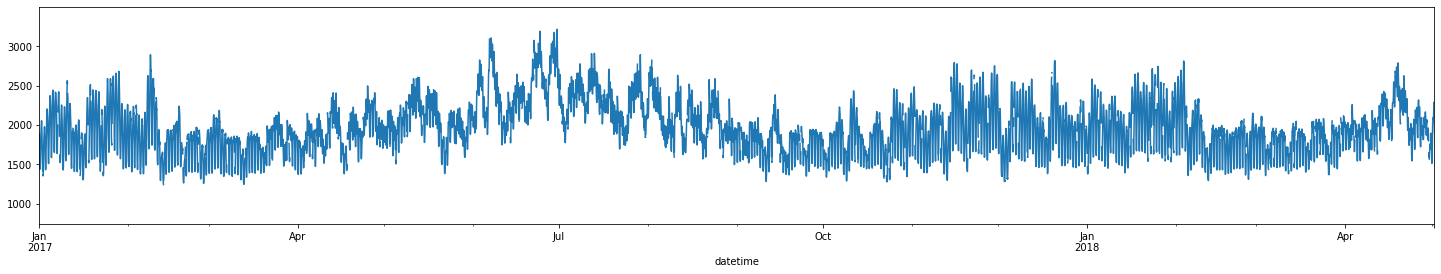

In [10]:
train['energy'].plot(xlim=['2017-01-01','2018-05-02'],figsize=(25,4))

<AxesSubplot:xlabel='datetime'>

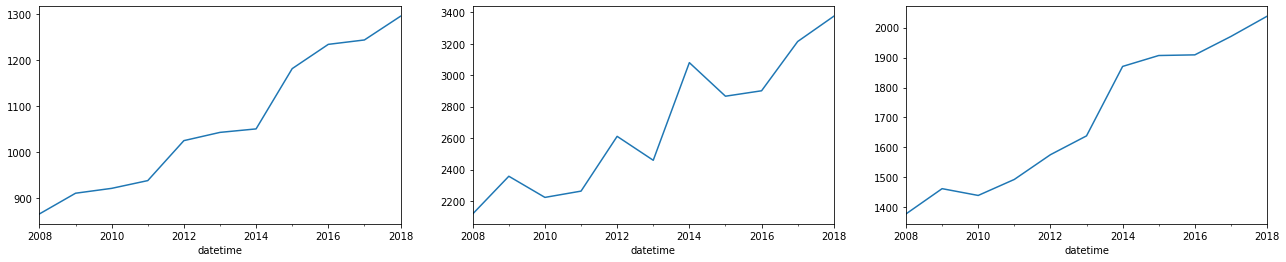

In [11]:
#year end frequency(rule='A')
pltfig,ax=plt.subplots(1,3,figsize=(22,4))

plt.subplot(1,3,1)
train.resample(rule='A').min()['energy'].plot()

plt.subplot(1,3,2)
train.resample(rule='A').max()['energy'].plot()

plt.subplot(1,3,3)
train.resample(rule='A').mean()['energy'].plot()

In [12]:
train_avg=train.copy()

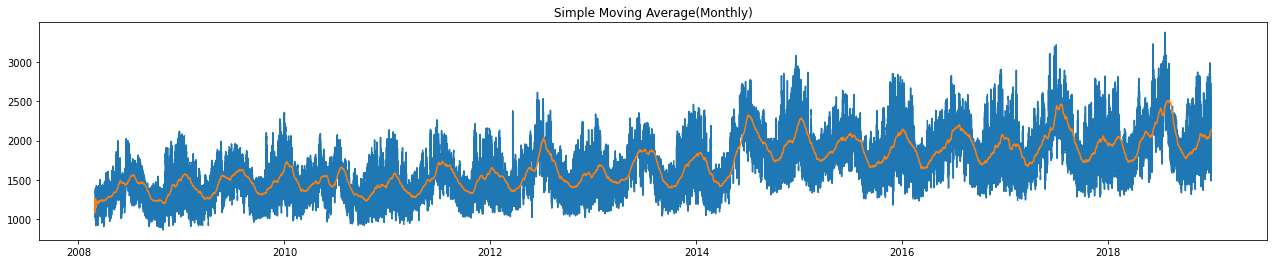

In [13]:
#Simple Moving Average
train_avg['rolling_energy']=train_avg['energy'].rolling(720,min_periods=0).mean()
fig,ax=plt.subplots(figsize=(22,4))
plt.title('Simple Moving Average(Monthly)')
ax.plot(train_avg[['energy','rolling_energy']])
plt.show()

<AxesSubplot:xlabel='datetime'>

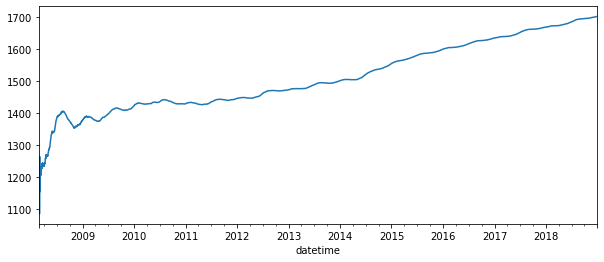

In [14]:
#cummulative moving average (Expanding)
train_avg['energy'].expanding().mean().plot(figsize=(10,4))

<AxesSubplot:xlabel='datetime'>

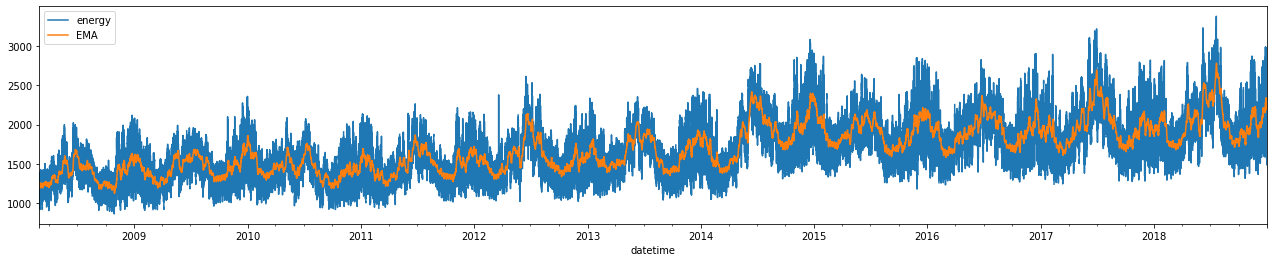

In [15]:
#Exponential Moving Average
train_avg['EMA']=train_avg['energy'].ewm(alpha=0.01,adjust=False).mean()
train_avg[['energy','EMA']].plot(figsize=(22,4))

<AxesSubplot:xlabel='datetime'>

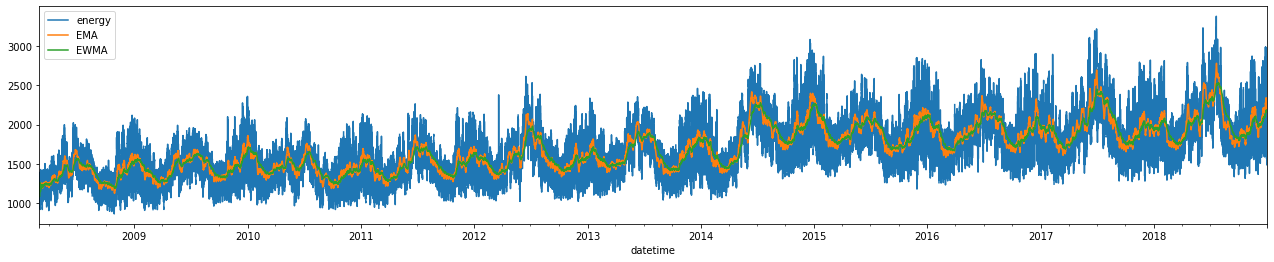

In [16]:
#Exponential Weighted Moving Average
train_avg['EWMA']=train_avg['energy'].ewm(span=720).mean()
#Comparison
train_avg[['energy','EMA','EWMA']].plot(figsize=(22,4))

Text(0.5, 1.0, 'Time Plot of energy')

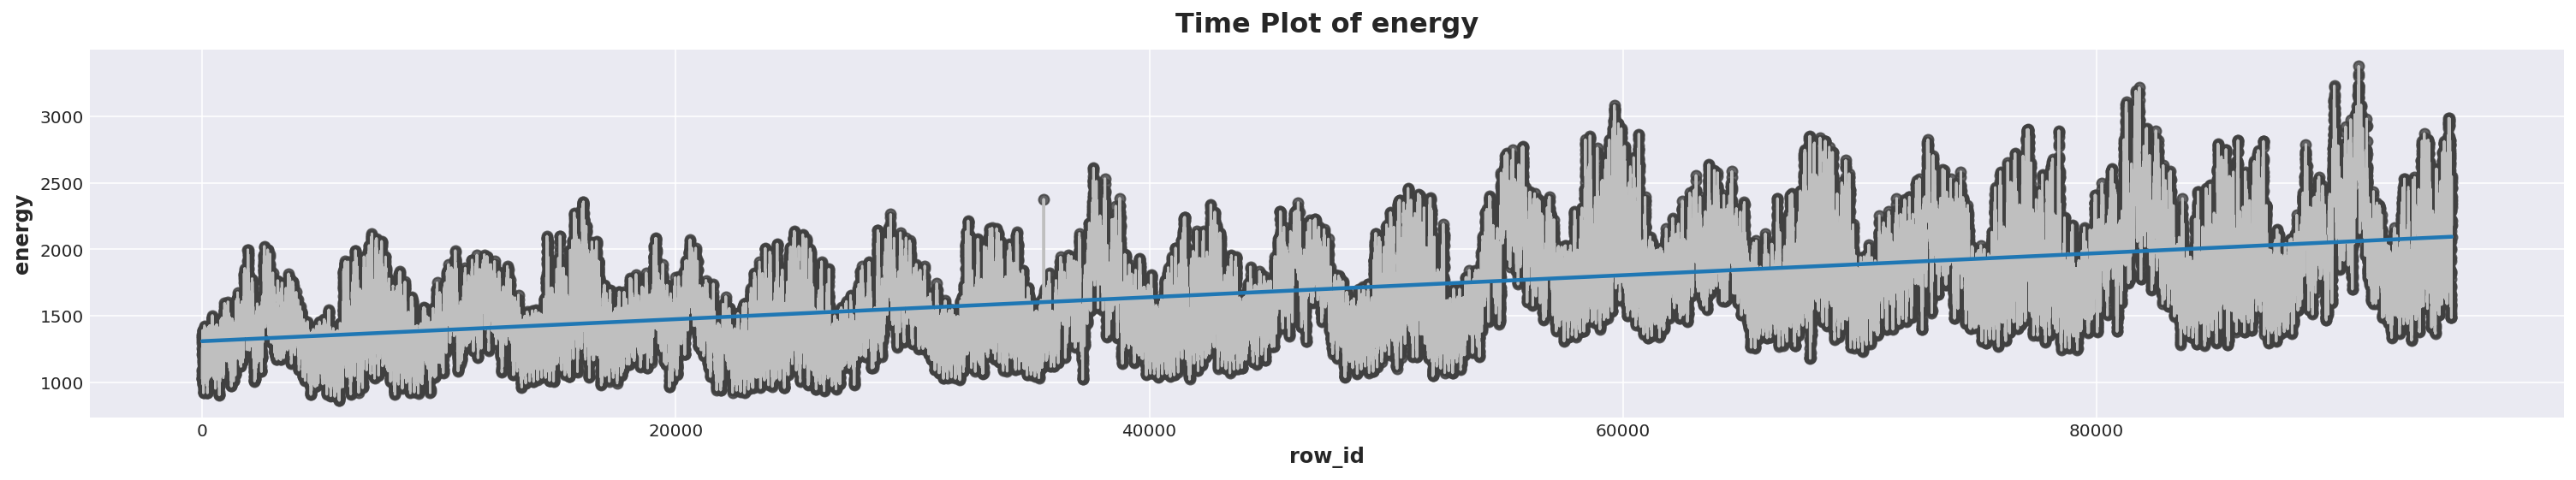

In [17]:
plt.style.use('seaborn-darkgrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(21, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'
   
fig,ax = plt.subplots()
ax.plot('row_id', 'energy', data=train, color='0.75')
ax = sns.regplot(x='row_id', y='energy', data=train, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of energy')

In [18]:
train_1=train.copy()
train_1['lag_1']=train_1['energy'].shift(1)
train_1['rolling_energy']=train_1['energy'].rolling(720,min_periods=0).mean()
train_1=train_1.reindex(columns=['energy','lag_1','rolling_energy'])
train_1.isnull().sum()

energy            1900
lag_1             1901
rolling_energy       0
dtype: int64

In [19]:
train_avg

,row_id,energy,time,rolling_energy,EMA,EWMA
datetime,,,,,,
2008-03-01 00:00:00,1,1259.985563,0.0,1259.985563,1259.985563,1259.985563
2008-03-01 01:00:00,2,1095.541500,1.0,1177.763531,1258.341122,1177.649334
2008-03-01 02:00:00,3,1056.247500,2.0,1137.258187,1256.320186,1137.069595
2008-03-01 03:00:00,4,1034.742000,3.0,1111.629141,1254.104404,1111.381006
2008-03-01 04:00:00,5,1026.334500,4.0,1094.570213,1251.826705,1094.277078
...,...,...,...,...,...,...
2018-12-31 19:00:00,94988,2528.446800,94987.0,2131.305835,2201.898877,2160.334701
2018-12-31 20:00:00,94989,2461.883600,94988.0,2132.186253,2204.498724,2161.184739
2018-12-31 21:00:00,94990,2365.994400,94989.0,2132.950363,2206.113681,2161.762053


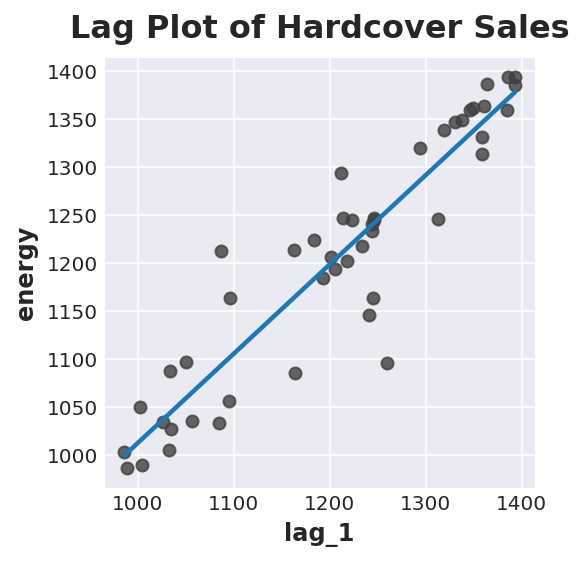

In [20]:
fig,ax=plt.subplots()
ax = sns.regplot(x='lag_1', y='energy', data=train_1.loc['2008-03-01':'2008-03-02'], ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

In [21]:
train.isnull().sum()

row_id       0
energy    1900
time         0
dtype: int64

In [22]:
train=train.bfill()

In [23]:
train_1=train_1.replace(np.nan,0)
train_1

,energy,lag_1,rolling_energy
datetime,,,
2008-03-01 00:00:00,1259.985563,0.000000,1259.985563
2008-03-01 01:00:00,1095.541500,1259.985563,1177.763531
2008-03-01 02:00:00,1056.247500,1095.541500,1137.258187
2008-03-01 03:00:00,1034.742000,1056.247500,1111.629141
2008-03-01 04:00:00,1026.334500,1034.742000,1094.570213
...,...,...,...
2018-12-31 19:00:00,2528.446800,2547.679200,2131.305835
2018-12-31 20:00:00,2461.883600,2528.446800,2132.186253
2018-12-31 21:00:00,2365.994400,2461.883600,2132.950363


In [24]:
# Splitting data
X = train.loc[:, ['row_id']]  # features
X_val=test.loc[:,['row_id']]
y = train_avg.loc[:, ['EWMA']]  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [25]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)
y_val=pd.DataFrame(model.predict(X_val), index=X_val.index)

In [26]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 155.09
Test RMSE: 188.88


In [27]:
print((f"Train R2: {r2_score(y_train,y_fit):.2f}\n" f"Test R2: {r2_score(y_test,y_pred):.2f}"))

Train R2: 0.60
Test R2: -0.01


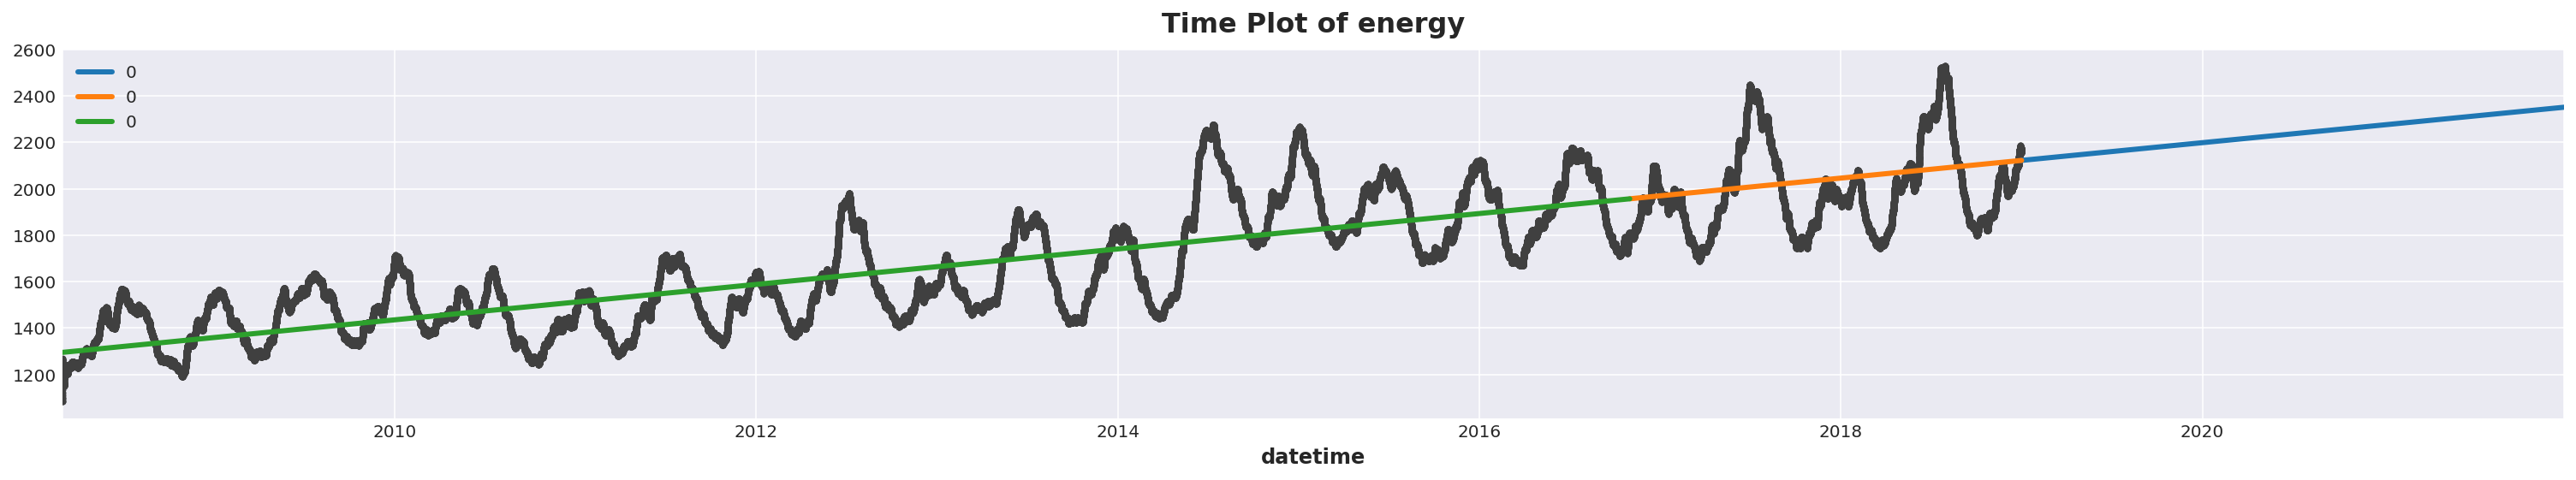

In [28]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = y.plot(**plot_params)
ax = y_val.plot(ax=ax, linewidth=3)
ax=y_pred.plot(ax=ax,linewidth=3)
ax=y_fit.plot(ax=ax,linewidth=3)
ax.set_title('Time Plot of energy');

In [29]:
y_val.values

array([[2122.06470331],
       [2122.07341226],
       [2122.08212121],
       ...,
       [2351.11881623],
       [2351.12752518],
       [2351.13623413]])